In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
from dynamic_routing_analysis import plot_utils
# from dynamic_routing_analysis import spike_utils

import os
import pingouin as pg

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [134]:
# session_table.to_pandas().query('subject_id == 748098')

In [51]:
# results_path=r's3://aind-scratch-data/dynamic-routing/decoding/results/binsize_0.5_sec_0/'
# results_path=r's3://aind-scratch-data/dynamic-routing/decoding/results/binsize_1.5_sec_0/'
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/rewarded_modality_1.5sec_0/" #1.5 sec - typical context decoding
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_response_1.5sec_0/" #1.5 sec - context appropriate response
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_response_1_5sec_incl_hits_0/" # 1.5 sec - context appropriate response including hits

# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_response_1_5sec_control_0/" #decode rewarded_modality with same trials as context_appropriate_response (is_target=True)

# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_for_response_0_5sec_0/"
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_for_response_0_2sec_0/"

# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_for_response_control_0_5sec_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_w_shifts_min_10_units_500ms_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_20251215_214910/" #blockwise crossval with repeats and linear shift (example)
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_5fold_crossval_w_repeats_and_linear_shift_20251215_220056/" #5fold crossval with repeats and linear shift (example)
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_strict_unit_drift_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_strict_drift_20_units_0/"
results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_strict_unit_drift_0/"

# session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    pl.col('is_good_behavior').eq(True),
    pl.col('is_engaged').eq(True),
    )['session_id'].to_list()
    )

In [52]:
dr_session_list

['626791_2022-08-15',
 '626791_2022-08-16',
 '636766_2023-01-23',
 '636766_2023-01-24',
 '636766_2023-01-25',
 '636766_2023-01-26',
 '644864_2023-01-30',
 '644864_2023-01-31',
 '644864_2023-02-02',
 '644866_2023-02-08',
 '644866_2023-02-09',
 '644866_2023-02-10',
 '649943_2023-02-13',
 '649943_2023-02-14',
 '649943_2023-02-15',
 '649943_2023-02-16',
 '644867_2023-02-20',
 '644867_2023-02-22',
 '644867_2023-02-23',
 '660023_2023-08-09',
 '666986_2023-08-14',
 '666986_2023-08-15',
 '666986_2023-08-17',
 '662892_2023-08-22',
 '662892_2023-08-23',
 '662892_2023-08-24',
 '668755_2023-08-28',
 '668755_2023-08-31',
 '667252_2023-09-26',
 '667252_2023-09-28',
 '674562_2023-10-02',
 '674562_2023-10-03',
 '674562_2023-10-04',
 '674562_2023-10-05',
 '681532_2023-10-18',
 '686740_2023-10-24',
 '686740_2023-10-25',
 '686740_2023-10-26',
 '664851_2023-11-13',
 '664851_2023-11-15',
 '664851_2023-11-16',
 '690706_2023-11-28',
 '690706_2023-11-30',
 '686176_2023-12-04',
 '686176_2023-12-07',
 '702131_2

In [5]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_size',
    'bin_center',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [33]:
# structure-wise average decoding accuracy

new_results_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').n_unique().ge(1).over('structure', 'unit_subsample_size')#, 'unit_criteria'),
    )
    # # get the means for each recording over their shifts:
    # .group_by(grouping_cols | {'repeat_idx'})
    # .agg(
    #     pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
    #     pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
    #     pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
    #         pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
    #     ).alias('mean_diff')
    # )
    # # get the means over repeats:
    # .group_by(grouping_cols)
    # .agg(
    #     pl.col('mean_true').mean(),
    #     pl.col('median_null').mean(),
    #     pl.col('mean_diff').mean()
    # )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    .group_by(grouping_cols)
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    )
    # get the means over sessions:
    .group_by('structure', 'unit_subsample_size','bin_size','bin_center')#, 'unit_criteria')
    .agg(
        pl.col('mean_true').mean(),
        pl.col('mean_true').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_true'),
        pl.col('median_null').mean(),
        pl.col('median_null').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_null'),
        pl.col('mean_diff').mean(),
        pl.col('mean_diff').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_diff'),
        pl.col('session_id').n_unique().alias('num_sessions')
    )
    .with_columns(
        pl.col('num_sessions').cast(pl.Int64),
    )
    .sort(pl.col('mean_diff').mean().over('structure'), descending=True)
    .collect()
)



In [ ]:
# new_results_df.to_pandas().query('structure.str.contains("SC")')['structure'].unique()

In [34]:
new_results_pd=new_results_df.to_pandas()
new_results_pd

,structure,unit_subsample_size,bin_size,bin_center,mean_true,sem_true,median_null,sem_null,mean_diff,sem_diff,num_sessions
0,SCdg,10,0.5,-0.25,0.845363,NaN,0.622152,NaN,0.223211,NaN,1
1,PPN,10,0.5,-0.25,0.777021,NaN,0.568625,NaN,0.208396,NaN,1
2,SNr,10,0.5,-0.25,0.772906,NaN,0.601634,NaN,0.171272,NaN,1
3,AMv,10,0.5,-0.25,0.637128,NaN,0.474330,NaN,0.162798,NaN,1
4,AD,10,0.5,-0.25,0.504080,NaN,0.346763,NaN,0.157317,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
131,ENTl,10,0.5,-0.25,0.452987,0.036225,0.456049,0.010456,-0.003062,0.025769,2
132,NB,10,0.5,-0.25,0.471803,0.018967,0.480421,0.007606,-0.008618,0.011384,3
133,CA2,10,0.5,-0.25,0.458609,NaN,0.480859,NaN,-0.022251,NaN,1
134,IG,10,0.5,-0.25,0.418379,NaN,0.441526,NaN,-0.023147,NaN,1


In [35]:
#filter out specific SC substructures
new_results_pd = new_results_pd[~new_results_pd['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg')]

In [ ]:
# new_results_pd.query('structure.str.contains("SC")')['structure'].unique()
# savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15"

In [ ]:
new_results_pd.to_parquet(os.path.join(savepath,"structure_wise_decoding_accuracy.parquet"))

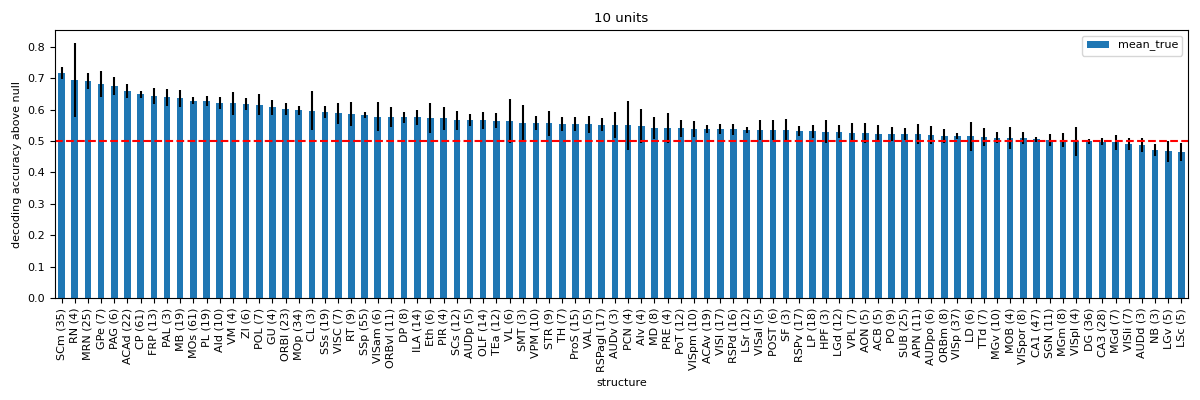

In [46]:
plot_column='true' #true, null, diff
min_n_sessions=3
for uu in new_results_pd['unit_subsample_size'].unique():
    fig,ax=plt.subplots(1,1,figsize=(12,4))
    structure_labels=[]
    if np.isnan(uu):
        plot_data=new_results_pd.query('unit_subsample_size.isna() and num_sessions>=@min_n_sessions').sort_values(by=f'mean_{plot_column}',ascending=False)
        plot_data.plot.bar(ax=ax,x='structure',y=[f'mean_{plot_column}'],yerr=f'sem_{plot_column}',rot=90)
        title_str='All units'
        for i in range(plot_data.shape[0]):
            structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(int(plot_data['num_sessions'].iloc[i]))+')')
    else:
        plot_data=new_results_pd.query('unit_subsample_size==@uu and num_sessions>=@min_n_sessions').sort_values(by=f'mean_{plot_column}',ascending=False)
        plot_data.plot.bar(ax=ax,x='structure',y=[f'mean_{plot_column}'],yerr=f'sem_{plot_column}',rot=90)
        title_str=f'{int(uu)} units'
        for i in range(plot_data.shape[0]):
            structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(int(plot_data['num_sessions'].iloc[i]))+')')

    ax.set_ylabel('decoding accuracy above null')
    ax.set_title(title_str)
    ax.set_xticklabels(structure_labels,rotation=90,ha='center')
    ax.axhline(0.5, color='red', linestyle='--')
    fig.tight_layout()


In [27]:
# type(new_results_pd['num_sessions'].iloc[0])
# type(min_n_sessions)

In [ ]:
new_results_pd.query(query_string)['structure']

In [ ]:
#plot on CCF

sel_n_units=20
sel_bin_center=-0.25
min_n_sessions=3

if sel_n_units == 'all':
    query_string='unit_subsample_size.isna() and bin_center==@sel_bin_center'# and num_sessions>=@min_n_sessions'
else:
    query_string='unit_subsample_size==@sel_n_units and bin_center==@sel_bin_center'# and num_sessions>=@min_n_sessions'

chart,x = plot_utils.plot_brain_heatmap(
    regions=new_results_pd.query(query_string)['structure'],
    values=new_results_pd.query(query_string)['mean_diff'],
    # values=np.ones(new_results_pd.query(query_string).shape[0])*0.027,
    # sagittal_planes=(-250,-500,-750,-1000,-1500,-2000,-3000),
    sagittal_planes=(-300,-1000,-2000,),
    # sagittal_planes=(-1500),
    cmap='Reds',
    # cmap='Greys',
    clevels=(0.02,0.14),
    # clevels=(0.55,0.8),
    # labels=True,
    # labels_on_areas=True,
    interactive=True,
    annotation_params={
        'fontsize':6,
    }
)

plt.savefig(os.path.join(savepath,"decoding_realbrain_heatmap_raw_acc.png"),dpi=600,bbox_inches='tight')

In [ ]:
### gap between SCs and SCm -- Why??


In [ ]:
chart.show()

In [ ]:
#accuracy vs. n units for a subset of structures

sel_structures=['SCm','MRN','MOs','FRP','ACAd','CP','PL','ORBl','CA1','VISp']

for ss in sel_structures:
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    
    for uu in plot_data['unit_subsample_size'].unique():
        if np.isnan(uu):
            xcoord=np.nanmax(plot_data['unit_subsample_size'])+10
            ycoord=plot_data.query('unit_subsample_size.isna()')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size.isna()')['num_sessions'].values[0]
        else:
            xcoord=uu
            ycoord=plot_data.query('unit_subsample_size==@uu')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size==@uu')['num_sessions'].values[0]

        ax.text(xcoord,ycoord,temp_str,ha='center',va='bottom')

    ax.set_ylabel('decoding accuracy above null')
    ax.set_xlabel('unit subsample size')
    ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
    ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
    ax.set_title(ss)
    ax.set_ylim([0,0.2])
    fig.tight_layout()

#plot all on same figure
fig,ax=plt.subplots(1,1,figsize=(5,4))
for ss in sel_structures:
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    line=ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',label=ss)
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',
                color=line[0].get_color())
    
ax.legend()
ax.set_ylabel('decoding accuracy above null')
ax.set_xlabel('unit subsample size')
ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
ax.set_ylim([0,0.2])
fig.tight_layout()

In [53]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modality_dprime_vis_blocks',
            'cross_modality_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                           'cross_modality_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
        pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    )
    .sort('structure', 'unit_subsample_size', descending=False)
    .collect()
)


In [ ]:
# float(new_results_session_df['cross_modal_dprime_aud_blocks'][0].split(';')[0])

# session_table.columns

In [54]:
new_results_session_pd=new_results_session_df.to_pandas()


In [ ]:
new_results_session_pd.to_parquet(os.path.join(savepath,"session_wise_decoding_accuracy.parquet"),index=False)

In [55]:
new_results_session_pd#.columns

,cross_modality_dprime_aud_blocks,n_passing_blocks,total_n_units,cross_modality_dprime_vis_blocks,session_id,unit_subsample_size,bin_size,structure,bin_center,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
0,"[1.9266322952977075, 1.8012222443167132, 2.643...",5,165.0,"[1.1517244571738332, 2.1934592095136844, 0.728...",666986_2023-08-14,10,0.5,ACAd,-0.25,0.740683,0.580091,"[0.38908668367670196, 0.3901755508282815, 0.39...","[-37, -36, -35, -34, -33, -32, -31, -30, -29, ...",0.160592
1,"[2.555537752965955, 2.117770946477709, 1.70163...",6,500.0,"[3.638942459221412, 2.6351136473658574, 2.0755...",674562_2023-10-04,10,0.5,ACAd,-0.25,0.562088,0.517515,"[0.4763266915494306, 0.46569371231696816, 0.46...","[-43, -42, -41, -40, -39, -38, -37, -36, -35, ...",0.044574
2,"[3.34390488927522, 3.2838404476079495, 1.80904...",6,103.0,"[2.993226872054329, 2.847489633345683, 1.73980...",737403_2024-09-24,10,0.5,ACAd,-0.25,0.405482,0.372627,"[0.37418533227995787, 0.3726776759668944, 0.36...","[-45, -44, -43, -42, -41, -40, -39, -38, -37, ...",0.032855
3,"[2.223431400046347, 1.718207422043472, 1.46716...",6,148.0,"[2.728238660827904, 3.335300476176423, 2.57776...",743199_2024-12-05,10,0.5,ACAd,-0.25,0.741876,0.585723,"[0.5009011975206779, 0.49949859366534005, 0.50...","[-46, -45, -44, -43, -42, -41, -40, -39, -38, ...",0.156153
4,"[1.539580547252192, 0.4899129578012258, 1.2160...",5,130.0,"[2.066435381481821, 2.0867242116239924, 2.7113...",690706_2023-11-28,10,0.5,ACAd,-0.25,0.544042,0.487686,"[0.417458510327653, 0.4162456342235933, 0.4213...","[-45, -44, -43, -42, -41, -40, -39, -38, -37, ...",0.056355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,"[1.6846742588763286, 1.7715327635693143, 1.011...",5,74.0,"[3.16943558095915, 2.516271686870029, -0.19297...",733891_2024-09-16,10,0.5,ZI,-0.25,0.599649,0.558549,"[0.5405537425537426, 0.5367867502867503, 0.533...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.041100
1212,"[3.055519590076932, 3.2764017778715275, 1.8732...",5,45.0,"[2.5552824516124693, 1.851385605391591, -0.232...",662892_2023-08-24,10,0.5,lot,-0.25,0.671141,0.554593,"[0.3480212219477917, 0.36090550844875485, 0.37...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.116548
1213,"[1.3211268869038646, 1.3357712541723485, 1.712...",6,37.0,"[3.88993352943941, 1.9491931817883839, 1.95467...",702131_2024-02-26,10,0.5,out of brain,-0.25,0.495002,0.475661,"[0.44705256255548653, 0.45078821698119936, 0.4...","[-43, -42, -41, -40, -39, -38, -37, -36, -35, ...",0.019341
1214,"[3.055519590076932, 3.2764017778715275, 1.8732...",5,90.0,"[2.5552824516124693, 1.851385605391591, -0.232...",662892_2023-08-24,10,0.5,root,-0.25,0.769599,0.621776,"[0.3932802495121917, 0.37513041947576037, 0.37...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.147824


In [97]:
sel_structure='GPe'

values=new_results_session_pd.query('structure==@sel_structure')['mean_true'].values-0.5

stats.ttest_1samp(values, 0)

TtestResult(statistic=4.437902230972005, pvalue=0.004385707998763852, df=6)

In [69]:
s1='MOs'
s2='SSp'

values1=new_results_session_pd.query('structure==@s1')['mean_true'].values-0.5
values2=new_results_session_pd.query('structure==@s2')['mean_true'].values-0.5

stats.mannwhitneyu(values1,values2)

MannwhitneyuResult(statistic=2153.0, pvalue=0.00863176199181572)

In [98]:
#calculate statistical difference from chance (0.5) for each structure
#save p value and mean_true values

structure_decoding_significance={
    'structure': [],
    'p_value': [],
    'statistic': [],
    'mean_true': [],
    'sem_true': [],
}

min_n_sessions=3
for sel_structure in new_results_session_pd['structure'].unique():
    structure_table=new_results_session_pd.query('structure==@sel_structure')
    if structure_table.shape[0]<min_n_sessions:
        continue
    values=structure_table['mean_true'].values-0.5
    stat,p_value=stats.ttest_1samp(values, 0)
    structure_decoding_significance['structure'].append(sel_structure)
    structure_decoding_significance['p_value'].append(p_value)
    structure_decoding_significance['statistic'].append(stat)
    structure_decoding_significance['mean_true'].append(np.mean(structure_table['mean_true'].values))
    structure_decoding_significance['sem_true'].append(stats.sem(structure_table['mean_true'].values))

#adjust pvals with BH correction
pvals=np.array(structure_decoding_significance['p_value'])
rej, pvals_corrected = pg.multicomp(pvals, alpha=0.05, method='fdr_bh')

structure_decoding_significance['p_value_corrected']=pvals_corrected

structure_decoding_significance_df=pd.DataFrame(structure_decoding_significance)
structure_decoding_significance_df

,structure,p_value,statistic,mean_true,sem_true,p_value_corrected
0,ACAd,2.292788e-07,7.497496,0.659855,0.021321,0.000003
1,ACAv,9.323965e-03,2.910863,0.538543,0.013241,0.038143
2,ACB,4.327157e-01,0.871397,0.523265,0.026698,0.577634
3,AId,1.342703e-04,6.341167,0.620906,0.019067,0.000911
4,AIv,4.428528e-01,0.881724,0.548406,0.054900,0.577634
...,...,...,...,...,...,...
85,VL,4.085749e-01,0.901647,0.564034,0.071018,0.574559
86,VM,5.073891e-02,3.163375,0.619787,0.037867,0.123738
87,VPL,4.222185e-01,0.861172,0.526454,0.030719,0.577000
88,VPM,2.998755e-02,2.574057,0.558264,0.022635,0.093065


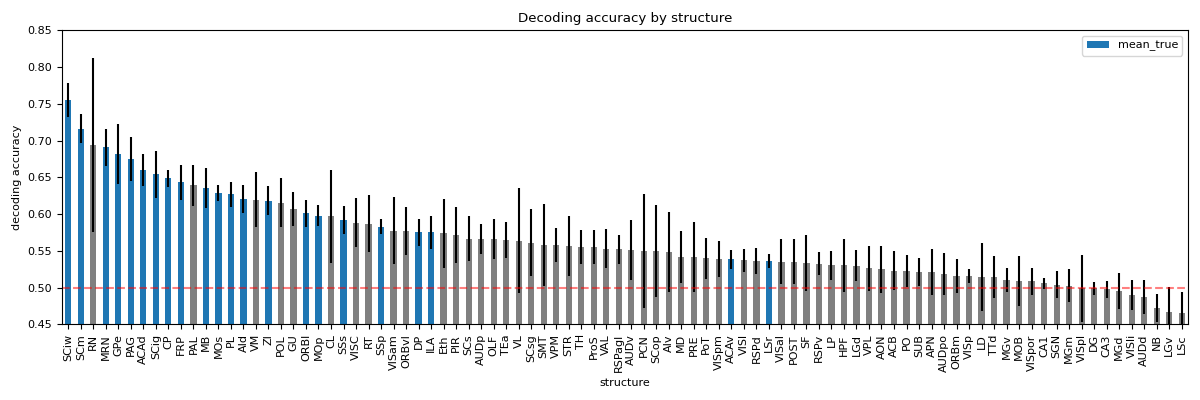

In [99]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
structure_labels=[]
plot_data=structure_decoding_significance_df.sort_values(by='mean_true',ascending=False)

significance=plot_data['p_value_corrected']<0.05

#make bars red if significant, grey if not significant
bars=plot_data.plot.bar(ax=ax,x='structure',y=['mean_true'],yerr='sem_true',rot=90)

# Change face color based on significance
for i, (bar, is_sig) in enumerate(zip(bars.patches, significance)):
    if not is_sig:
        bar.set_facecolor('grey')

for i in range(plot_data.shape[0]):
    structure_labels.append(plot_data['structure'].iloc[i])

ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)

ax.set_ylim([0.45,0.85])
ax.set_ylabel('decoding accuracy')
ax.set_xlabel('structure')
ax.set_title('Decoding accuracy by structure')
ax.set_xticklabels(structure_labels,rotation=90,ha='center')
fig.tight_layout()


In [86]:
bars

<Axes: title={'center': 'Decoding accuracy by structure'}, xlabel='structure', ylabel='decoding accuracy'>

In [ ]:
# barplot for one structure across sessions

matplotlib.rcParams['font.size'] = 10

#plot boxplot of chosen variable for list of structures
structure_query='ORBm|ORBvl|ORBl'
# structure_list=['ORBm','ORBvl','ORBl']
structure_list=['ORB']

sel_column='context'

fig,ax=plt.subplots(1,1,figsize=(1.5,3))

for ss,structure_query in enumerate(structure_list):

    session_wise_results=new_results_session_pd.query('structure.str.contains(@structure_query) and session_id in @dr_session_list')

    data = session_wise_results['mean_true'].values
    ax.boxplot(data,positions=[ss], widths=0.6, showfliers=False, medianprops=dict(color='black'))

    #jittered scatter plot of individual data points
    ax.scatter(np.random.normal(ss, 0.1, size=data.shape), data, alpha=0.2, color='k')

#remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(len(structure_list)))
ax.set_xticklabels(structure_list,rotation=45,ha='right')
ax.set_yticks(np.arange(0.5,0.91,0.1))
ax.set_ylabel('context decoding accuracy')
ax.set_ylim(0.5,0.9)
fig.tight_layout()

In [ ]:

figsavepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-27-muscimol_sfn_poster"
fig.savefig(os.path.join(figsavepath,'context_decoding_accuracy_ORB_combined.png'),dpi=300)

In [ ]:
sessions_with_enough_units = (
    new_results_session_df
    .group_by('session_id','structure','n_passing_blocks')
    .agg(
        pl.col('unit_subsample_size','mean_true', 'median_null','mean_diff'),
    )
)

In [ ]:
max_n_units=40
sel_structures=['SCm','MRN','MOs','FRP','ACAd','CP','PL','ORBl','CA1','VISp']

fig,ax=plt.subplots(1,1,figsize=(5,4))
for sel_structure in sel_structures:

    sessions_with_enough_units_pd=sessions_with_enough_units.filter(
        pl.col('structure')==sel_structure,
        pl.col('unit_subsample_size').list.contains(max_n_units),
        pl.col('n_passing_blocks').ge(4)
    ).to_pandas()

    plot_data=sessions_with_enough_units_pd


    xvect=np.arange(len(plot_data['unit_subsample_size'].iloc[0]))
    xlabels=plot_data['unit_subsample_size'].iloc[0]

    line=ax.errorbar(xvect[~np.isnan(xlabels)],np.mean(np.vstack(plot_data['mean_diff'].values),axis=0)[~np.isnan(xlabels)],
                    yerr=stats.sem(np.vstack(plot_data['mean_diff'].values),axis=0)[~np.isnan(xlabels)],marker='o',
                    label=sel_structure+f' ({len(plot_data)})')

    #plot nan value at the end of the plot
    ax.errorbar(xvect[-1]+1,np.mean(np.vstack(plot_data['mean_diff'].values),axis=0)[np.isnan(xlabels)],
                yerr=stats.sem(np.vstack(plot_data['mean_diff'].values),axis=0)[np.isnan(xlabels)],marker='o',color=line[0].get_color())
    
ax.legend()
ax.set_ylabel('decoding accuracy above null')
ax.set_xlabel('unit subsample size')
ax.set_xticks(xvect+1)
ax.set_xticklabels(list(xlabels[1:])+['all_units'])
ax.set_ylim([0,0.2])
fig.tight_layout()



In [ ]:
~np.isnan(xlabels)

In [ ]:
#accuracy vs. n units for a subset of structures

sel_structures=['SCm','MRN','MOs','FRP','ACAd','CP','PL','ORBl','CA1','VISp']

for ss in sel_structures:
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    
    for uu in plot_data['unit_subsample_size'].unique():
        if np.isnan(uu):
            xcoord=np.nanmax(plot_data['unit_subsample_size'])+10
            ycoord=plot_data.query('unit_subsample_size.isna()')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size.isna()')['num_sessions'].values[0]
        else:
            xcoord=uu
            ycoord=plot_data.query('unit_subsample_size==@uu')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size==@uu')['num_sessions'].values[0]

        ax.text(xcoord,ycoord,temp_str,ha='center',va='bottom')

    ax.set_ylabel('decoding accuracy above null')
    ax.set_xlabel('unit subsample size')
    ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
    ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
    ax.set_title(ss)
    ax.set_ylim([0,0.2])
    fig.tight_layout()

#plot all on same figure
fig,ax=plt.subplots(1,1,figsize=(5,4))
for ss in sel_structures:
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    line=ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',label=ss)
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',
                color=line[0].get_color())
    
ax.legend()
ax.set_ylabel('decoding accuracy above null')
ax.set_xlabel('unit subsample size')
ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
ax.set_ylim([0,0.2])
fig.tight_layout()

In [ ]:
# new_results_session_pd
all_units_table_path='s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet'
all_units_table=pd.read_parquet(all_units_table_path)


In [ ]:
#get mean ccf for each session-structure

session_structure_ccf_coords={
    'session_id':[],
    'structure':[],
    'ccf_dv':[],
    'ccf_ml':[],
    'ccf_ap':[]
}


for session_id in new_results_session_pd['session_id'].unique():
    session_pd=new_results_session_pd.query('session_id==@session_id')
    for structure in session_pd['structure'].unique():
        #get SCm, SCs
        if structure=='SCs':
            structure_query='(structure=="SCop" | structure=="SCsg" | structure=="SCzo")'
        elif structure=='SCm':
            structure_query='(structure=="SCig" | structure=="SCiw" | structure=="SCdg" | structure=="SCdw")'
        else:
            structure_query='structure==@structure'
        session_structure_units=all_units_table.query('session_id==@session_id & '+structure_query)
        ccf_dv=np.nanmean(session_structure_units['ccf_dv'].values)
        ccf_ml=np.nanmean(session_structure_units['ccf_ml'].values)
        ccf_ap=np.nanmean(session_structure_units['ccf_ap'].values)

        session_structure_ccf_coords['session_id'].append(session_id)
        session_structure_ccf_coords['structure'].append(structure)
        session_structure_ccf_coords['ccf_dv'].append(ccf_dv)
        session_structure_ccf_coords['ccf_ml'].append(ccf_ml)
        session_structure_ccf_coords['ccf_ap'].append(ccf_ap)

session_structure_ccf_coords_df=pd.DataFrame(session_structure_ccf_coords)


In [ ]:
new_results_session_with_ccf_pd=pd.merge(
    new_results_session_pd,
    session_structure_ccf_coords_df,
    on=['session_id','structure'],
    how='left'
)

In [ ]:
new_results_session_with_ccf_pd.query('structure=="SCm"')

In [ ]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from pathlib import Path

output_dir = r"D:\ccf_cache"
reference_space_key = "annotation/ccf_2022"
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')

# get structure tree
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 

# get id_acronym map
id_acronym_map = tree.get_id_acronym_map()

# make reference space object
rsp = rspc.get_reference_space()

In [ ]:
# area_mask

In [ ]:
# structure_list=['ORBl','ORBm','ORBvl','FRP','PL']
structure_list=['MOs']
# dprime_threshold=1.0

structure_id_list=[id_acronym_map[structure_list[0]]]

if len(structure_list)>1:
    for sel_area in structure_list[1:]:
        structure_id_list.append(id_acronym_map[sel_area])

area_mask=rsp.make_structure_mask(structure_id_list)

In [ ]:
# #get separate area masks

area_masks={}

for ss in structure_list:
    structure_id_list=[id_acronym_map[ss]]
    area_masks[ss]=rsp.make_structure_mask(structure_id_list)


In [ ]:
combined_area_mask=area_masks[structure_list[0]]
for ii,ss in enumerate(structure_list[1:]):
    combined_area_mask+=(area_masks[ss]*(ii+1))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.imshow(np.max(combined_area_mask[:,:,:],axis=0),cmap='magma',alpha=0.5)

In [ ]:
sel_structure='MOs'
sel_unit_subsample_size=10
plot_data=new_results_session_with_ccf_pd.query('structure==@sel_structure and n_passing_blocks>=5 and unit_subsample_size==@sel_unit_subsample_size')
# plot_data=new_results_session_with_ccf_pd.query(
#     '(structure=="ORBl" or structure=="ORBm" or structure=="ORBvl" or structure=="FRP" or structure=="PL") and \
#     n_passing_blocks>=5 and unit_subsample_size==@sel_unit_subsample_size')

#plot ccf_ap vs. ccf_ml vs. decoding accuracy

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.imshow(np.max(area_mask[:,:,:],axis=1),cmap='gray',alpha=0.5)
# ax.imshow(np.max(combined_area_mask[:,:,:],axis=1),cmap='magma',alpha=0.5)

ax.scatter((plot_data['ccf_ml']/10),plot_data['ccf_ap']/10,c=plot_data['mean_diff'],s=20,cmap='Reds',vmin=0,vmax=0.2)

ax.set_ylabel('CCF AP')
ax.set_xlabel('CCF ML')

#set xlim and ylim to be around the area mask
ax.set_xlim([np.nanmin(plot_data['ccf_ml']/10)-100,np.nanmax(plot_data['ccf_ml']/10)+100])
ax.set_ylim([np.nanmin(plot_data['ccf_ap']/10)-100,np.nanmax(plot_data['ccf_ap']/10)+100])

ax.invert_yaxis()

#make colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('decoding accuracy above null', rotation=90, labelpad=15)

ax.set_title(f'{sel_structure} {sel_unit_subsample_size} units; horizontal view')

# fig.tight_layout()

In [ ]:
#plot ccf_dv vs. ccf_ml vs. decoding accuracy

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.imshow(np.max(area_mask[:,:,:],axis=0),cmap='gray',alpha=0.5)
# ax.imshow(np.max(combined_area_mask[:,:,:],axis=0),cmap='magma',alpha=0.5)

ax.scatter((plot_data['ccf_ml']/10),plot_data['ccf_dv']/10,c=plot_data['mean_diff'],s=20,cmap='Reds',vmin=0,vmax=0.2)

ax.set_ylabel('CCF DV')
ax.set_xlabel('CCF ML')

#set xlim and ylim to be around the area mask
ax.set_xlim([np.nanmin(plot_data['ccf_ml']/10)-100,np.nanmax(plot_data['ccf_ml']/10)+100])
ax.set_ylim([np.nanmin(plot_data['ccf_dv']/10)-100,np.nanmax(plot_data['ccf_dv']/10)+100])

ax.invert_yaxis()

#make colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('decoding accuracy above null', rotation=90, labelpad=15)

ax.set_title(f'{sel_structure} {sel_unit_subsample_size} units; coronal view')



In [ ]:
#plot ccf_dv vs. ccf_ap vs. decoding accuracy

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.imshow(np.max(area_mask[:,:,:],axis=2).T,cmap='gray',alpha=0.5)
# ax.imshow(np.max(combined_area_mask[:,:,:],axis=2).T,cmap='magma',alpha=0.5)

ax.scatter((plot_data['ccf_ap']/10),plot_data['ccf_dv']/10,c=plot_data['mean_diff'],s=20,cmap='Reds',vmin=0,vmax=0.2)

ax.set_ylabel('CCF DV')
ax.set_xlabel('CCF AP')

#set xlim and ylim to be around the area mask
ax.set_xlim([np.nanmin(plot_data['ccf_ap']/10)-100,np.nanmax(plot_data['ccf_ap']/10)+100])
ax.set_ylim([np.nanmin(plot_data['ccf_dv']/10)-100,np.nanmax(plot_data['ccf_dv']/10)+100])

ax.invert_yaxis()

#make colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('decoding accuracy above null', rotation=90, labelpad=15)

ax.set_title(f'{sel_structure} {sel_unit_subsample_size} units; sagittal view')



In [ ]:
mean_cross_modal_dprime_vis_blocks=[]
mean_cross_modal_dprime_aud_blocks=[]

for rr, row in new_results_session_pd.iterrows():
    if row['cross_modal_dprime_aud_blocks'] is not None:
        temp_list=row['cross_modal_dprime_aud_blocks'].split(';')
        new_list=[]
        for ll in temp_list:
            new_list.append(float(ll))
        mean_cross_modal_dprime_aud_blocks.append(np.nanmean(new_list))
    else:
        mean_cross_modal_dprime_aud_blocks.append(np.nan)
    
    if row['cross_modal_dprime_vis_blocks'] is not None:
        temp_list=row['cross_modal_dprime_vis_blocks'].split(';')
        new_list=[]
        for ll in temp_list:
            new_list.append(float(ll))
        mean_cross_modal_dprime_vis_blocks.append(np.nanmean(new_list))
    else:
        mean_cross_modal_dprime_vis_blocks.append(np.nan)

new_results_session_pd['mean_cross_modal_dprime_vis_blocks']=mean_cross_modal_dprime_vis_blocks
new_results_session_pd['mean_cross_modal_dprime_aud_blocks']=mean_cross_modal_dprime_aud_blocks

new_results_session_pd['mean_cross_modal_dprime']=new_results_session_pd[['mean_cross_modal_dprime_vis_blocks','mean_cross_modal_dprime_aud_blocks']].mean(axis=1)

In [ ]:
new_results_session_pd

In [ ]:
# "all units" accuracy versus total_n_units

sel_structure='MOs'

fig,ax=plt.subplots(1,1,figsize=(5,4))

plot_data=new_results_session_pd.query('unit_subsample_size.isna() and structure==@sel_structure')
ax.scatter(plot_data['total_n_units'],
            plot_data['mean_true'],marker='.',color='k',
            label='true')

ax.scatter(plot_data['total_n_units'],
           plot_data['median_null'],marker='.',color='gray',alpha=0.5,
           label='null')

ax.set_ylabel('decoding accuracy')
ax.set_xlabel('total n units')
ax.set_title(sel_structure)
ax.legend()


In [ ]:
# example areas: true vs. null decoding accuracy



In [ ]:
# plot on CCF?



In [ ]:
# correlate session-wise accuracy with cross-modal dprime

sel_structure='SCm'

fig,ax=plt.subplots(1,1,figsize=(5,4))

plot_data=new_results_session_pd.query('unit_subsample_size==20 and structure==@sel_structure')

r,p=stats.pearsonr(plot_data[['mean_cross_modal_dprime_aud_blocks',
                      'mean_cross_modal_dprime_vis_blocks']].mean(axis=1),
                    plot_data['mean_diff'])

ax.scatter(plot_data[['mean_cross_modal_dprime_aud_blocks',
                      'mean_cross_modal_dprime_vis_blocks']].mean(axis=1),
            plot_data['mean_diff'],marker='.',color='k',
            label='true')

ax.set_ylabel('decoding accuracy above null')
ax.set_xlabel('mean cross-modal dprime')
ax.set_title(sel_structure+f' (r={r:.2f}, p={p:.3e})')

fig.tight_layout()


In [ ]:
# compare correlation across areas

decoding_accuracy_vs_dprime_by_structure={
    'structure':[],
    'unit_subsample_size':[],
    'r':[],
    'p':[],
}

for sel_structure in new_results_session_pd['structure'].unique():
    for sel_unit_subsample_size in new_results_session_pd['unit_subsample_size'].unique():

        if np.isnan(sel_unit_subsample_size):
            structure_data=new_results_session_pd.query('unit_subsample_size.isna() and structure==@sel_structure')
        else:
            structure_data=new_results_session_pd.query('unit_subsample_size==@sel_unit_subsample_size and structure==@sel_structure')

        if len(structure_data['mean_diff'])<10:
            continue

        r,p=stats.pearsonr(structure_data[['mean_cross_modal_dprime_aud_blocks','mean_cross_modal_dprime_vis_blocks']].mean(axis=1),
                            structure_data['mean_diff'])
        
        decoding_accuracy_vs_dprime_by_structure['structure'].append(sel_structure)
        if np.isnan(sel_unit_subsample_size):
            decoding_accuracy_vs_dprime_by_structure['unit_subsample_size'].append(np.nan)
        else:
            decoding_accuracy_vs_dprime_by_structure['unit_subsample_size'].append(sel_unit_subsample_size)
        decoding_accuracy_vs_dprime_by_structure['r'].append(r)
        decoding_accuracy_vs_dprime_by_structure['p'].append(p)

decoding_accuracy_vs_dprime_by_structure_df=pd.DataFrame(decoding_accuracy_vs_dprime_by_structure)


In [ ]:
new_results_session_pd['unit_subsample_size'].unique()

In [ ]:
sel_unit_subsample_size=20

fig,ax=plt.subplots(1,1,figsize=(12,4))

decoding_accuracy_vs_dprime_by_structure_df.query('unit_subsample_size==@sel_unit_subsample_size').sort_values(by='r',ascending=False).plot.bar(ax=ax,x='structure',y=['r'],rot=90)
ax.set_ylabel('correlation coefficient')
ax.set_title('correlation between decoding accuracy and cross-modal dprime')

fig.tight_layout()


In [ ]:
sel_structure='MRN'

plot_data=decoding_accuracy_vs_dprime_by_structure_df.query('structure==@sel_structure').sort_values(by='unit_subsample_size',ascending=True)[['unit_subsample_size','r']]
xvect=np.arange(0,plot_data.shape[0])

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(xvect,plot_data['r'],marker='o',color='k')
ax.set_xticks(xvect)
ax.set_xticklabels(plot_data['unit_subsample_size'].values)

ax.set_xlabel('unit subsample size')
ax.set_ylabel('correlation coefficient')
ax.set_title(sel_structure)

In [ ]:
# supplemental: plot shifts, null, etc. for a few example sessions

# also average across sessions


In [89]:
# sel_session='742903_2024-10-22'
# sel_session='715710_2024-07-15'
sel_session='670180_2023-07-27'
test_session_df=(
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        pl.col('session_id').eq(sel_session),
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
).collect()
test_session_df.to_pandas()['structure'].unique()

array(['VPM', 'ACAv', 'MOp', 'PO', 'ORBvl', 'ACAd', 'DG', 'CA3', 'LSr',
       'CA1', 'CP', 'PL', 'MOs', 'LD', 'VISp', 'VISa', 'ORBm'],
      dtype=object)

In [ ]:
# test_session_df.to_pandas()['structure'].unique()

In [114]:
# get all shifts for an example session and area
sel_session='742903_2024-10-22'
# sel_session='715710_2024-07-15'
# sel_session='670180_2023-07-27' #templeton
sel_area='ACAd'

example_session_df = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        pl.col('session_id').eq(sel_session),
        pl.col('structure').eq(sel_area),
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    .sort('shift_idx')
    .group_by(
        grouping_cols - {'electrode_group_names'}| {'repeat_idx'}, 
        maintain_order=True,
    )
    .agg(
        pl.col('balanced_accuracy_test', 'shift_idx'),
    ).sort('unit_subsample_size','repeat_idx')
    .collect()
)




In [115]:
example_session_df

session_id,bin_size,structure,unit_subsample_size,bin_center,repeat_idx,balanced_accuracy_test,shift_idx
str,f64,str,u16,f64,u16,list[f64],list[i16]
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,0,"[0.53094, 0.544206, … 0.561338]","[-43, -42, … 44]"
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,1,"[0.509804, 0.518604, … 0.424775]","[-43, -42, … 44]"
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,2,"[0.430994, 0.455189, … 0.475764]","[-43, -42, … 44]"
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,3,"[0.46825, 0.446094, … 0.46421]","[-43, -42, … 44]"
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,4,"[0.533073, 0.536675, … 0.437797]","[-43, -42, … 44]"
…,…,…,…,…,…,…,…
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,20,"[0.456282, 0.469243, … 0.385908]","[-43, -42, … 44]"
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,21,"[0.49868, 0.493144, … 0.497639]","[-43, -42, … 44]"
"""742903_2024-10-22""",0.5,"""ACAd""",10,-0.25,22,"[0.5738, 0.577552, … 0.520185]","[-43, -42, … 44]"


In [ ]:
# #without re-shaping

# example_session_allrows_df = (
#     pl.scan_parquet(results_path)
#     .with_columns(
#         pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
#     )
#     .filter(
#         pl.col('session_id').eq(sel_session),
#         pl.col('structure').eq(sel_area),
#         combine_multi_probe_expr,
#         pl.col('is_all_trials').not_(),
#     )
#     .drop('unit_ids','electrode_group_names','is_sole_recording','unit_criteria')
#     .sort('unit_subsample_size','repeat_idx','shift_idx')
# ).collect()

In [ ]:
# example_session_pd=example_session_allrows_df.to_pandas()
# example_session_pd

In [ ]:
# # repeat_idx=0
# sel_unit_subsample_size=20

# fig,ax=plt.subplots(1,1,figsize=(5,4))

# all_acc=[]

# for repeat_idx in example_session_pd['repeat_idx'].unique():
#     sub_table=example_session_pd.query('repeat_idx==@repeat_idx and unit_subsample_size==@sel_unit_subsample_size')
#     shifts=sub_table['shift_idx'].values
#     temp_acc=sub_table['balanced_accuracy_test'].values
#     all_acc.append(temp_acc)
#     ax.plot(shifts,temp_acc,color='k',linewidth=0.5,alpha=0.5)
    

# mean_acc=np.mean(np.vstack(all_acc),axis=0)

# ax.plot(shifts,mean_acc,color='k',linewidth=2,label='mean')

# aligned_acc=mean_acc[shifts==0]
# null_median_acc=np.median(mean_acc[shifts!=0])

# ax.set_title(f'session: {sel_session}, area: {sel_area} \n aligned_acc: {aligned_acc[0]:.3f}, null_median_acc: {null_median_acc:.3f}')


In [ ]:
# # shifts==0
# # all_acc
# aligned_acc
# null_median_acc

In [ ]:
# all_acc

In [ ]:
# np.nanmean(np.vstack(example_session_area['shift_idx']),axis=0)

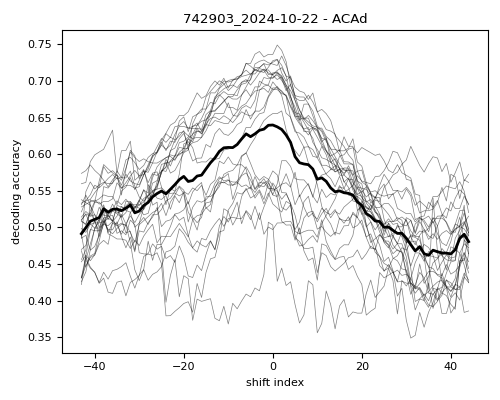

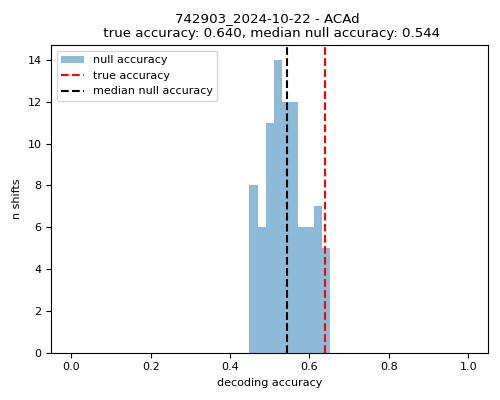

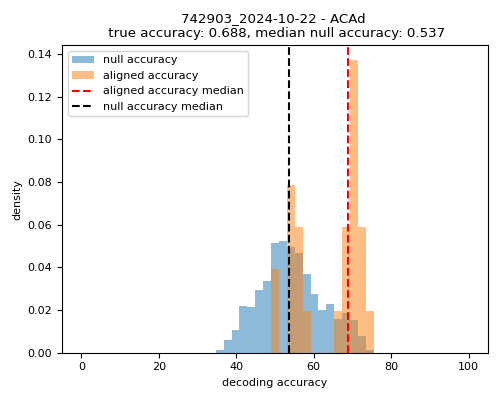

In [116]:
sel_n_units=10
example_session_area=example_session_df.to_pandas().query('unit_subsample_size==@sel_n_units')

mean_across_repeats=np.nanmean(np.vstack(example_session_area['balanced_accuracy_test'].values),axis=0)

# all_shifts_aligned=np.full((25,200),dtype=float,fill_value=np.nan)

fig,ax=plt.subplots(1,1,figsize=(5,4))
for rr, row in example_session_area.iterrows():
    ax.plot(row['shift_idx'],row['balanced_accuracy_test'],marker='',color='k',alpha=0.5,linewidth=0.5)
ax.set_xlabel('shift index')
ax.set_ylabel('decoding accuracy')
ax.set_title(f'{sel_session} - {sel_area}')

#take the mean of all repeats
ax.plot(row['shift_idx'],mean_across_repeats,color='k',label='mean across repeats',linewidth=2)

fig.tight_layout()

aligned_accuracy = mean_across_repeats[row['shift_idx']==0][0]
median_null_accuracy = np.median(mean_across_repeats[row['shift_idx']!=0])

# plot the true accuracy versus the histogram of the null accuracy
fig,ax= plt.subplots(1,1,figsize=(5,4))
xbins=np.linspace(0, 1, 50)
ax.hist(mean_across_repeats[row['shift_idx']!=0], bins=xbins, alpha=0.5, label='null accuracy')
ax.axvline(aligned_accuracy, color='r', linestyle='--', label='true accuracy')
ax.axvline(median_null_accuracy, color='k', linestyle='--', label='median null accuracy')
ax.set_xlabel('decoding accuracy')
ax.set_ylabel('n shifts')
ax.set_title(f'{sel_session} - {sel_area} \n true accuracy: {aligned_accuracy:.3f}, median null accuracy: {median_null_accuracy:.3f}')
ax.legend()
fig.tight_layout()

#get the full histogram of all shift-repeats
all_aligned_accuracy= np.vstack(example_session_area['balanced_accuracy_test'].values)[:,row['shift_idx']==0].flatten()
all_null_accuracy = np.vstack(example_session_area['balanced_accuracy_test'].values)[:,row['shift_idx']!=0].flatten()

all_aligned_accuracy_median= np.median(all_aligned_accuracy)
all_null_accuracy_median= np.median(all_null_accuracy)

fig,ax= plt.subplots(1,1,figsize=(5,4))
xbins=np.linspace(0, 100, 50)
ax.hist(all_null_accuracy*100, bins=xbins, alpha=0.5, label='null accuracy',density=True)
ax.hist(all_aligned_accuracy*100, bins=xbins, alpha=0.5, label='aligned accuracy', density=True)
ax.axvline(all_aligned_accuracy_median*100, color='r', linestyle='--', label='aligned accuracy median')
ax.axvline(all_null_accuracy_median*100, color='k', linestyle='--', label='null accuracy median')
ax.set_xlabel('decoding accuracy')
ax.set_ylabel('density')
ax.set_title(f'{sel_session} - {sel_area} \n true accuracy: {all_aligned_accuracy_median:.3f}, median null accuracy: {all_null_accuracy_median:.3f}')
ax.legend()
fig.tight_layout()


In [ ]:
new_results_session_pd.query('session_id=="742903_2024-10-22" and structure=="ACAd"')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

r,p=stats.pearsonr(new_results_session_pd['mean_true'],
                    new_results_session_pd['mean_diff'])

ax.plot(new_results_session_pd['mean_true'],new_results_session_pd['mean_diff'],'k.',alpha=0.2)
ax.set_xlabel('mean true accuracy')
ax.set_ylabel('decoding accuracy above null')
ax.set_title(f'r: {r:.3f}, p: {p:.3e}')

In [ ]:

all_mean_true=new_results_session_pd['mean_true'].values
all_balanced_accuracy_test=new_results_session_pd['balanced_accuracy_test'].values
all_percentile=[]

for tt, true_value in enumerate(all_mean_true):
    shift_values=all_balanced_accuracy_test[tt][all_balanced_accuracy_test[tt]!=true_value]
    percentile=stats.percentileofscore(shift_values,true_value)
    all_percentile.append(percentile)

new_results_session_pd['percentile']=all_percentile
new_results_session_pd['p_value']=1-(new_results_session_pd['percentile']/100)


In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

r,p=stats.pearsonr(new_results_session_pd['mean_true'],
                    new_results_session_pd['p_value'])

ax.plot(new_results_session_pd['mean_true'],new_results_session_pd['p_value'],'k.',alpha=0.2)
ax.set_yscale('log')
ax.set_xlabel('mean true accuracy')
ax.set_ylabel('p-value')
ax.set_title(f'r: {r:.3f}, p: {p:.3e}')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

r,p=stats.pearsonr(new_results_session_pd['mean_diff'],
                    new_results_session_pd['p_value'])

ax.plot(new_results_session_pd['mean_diff'],new_results_session_pd['p_value'],'k.',alpha=0.2)
ax.set_yscale('log')
ax.set_xlabel('mean accuracy above null')
ax.set_ylabel('p-value')
ax.set_title(f'r: {r:.3f}, p: {p:.3e}')

In [ ]:
not_nan_vals=~np.isnan(np.log10(new_results_session_pd['p_value'].values))
stats.pearsonr(new_results_session_pd['mean_true'].values[not_nan_vals],np.log10(new_results_session_pd['p_value'].values[not_nan_vals]))

In [ ]:
new_results_session_pd

In [ ]:
#anova on structure, n_passing_blocks 
pg.anova(new_results_session_pd.query('unit_subsample_size==20'), dv='mean_diff', between=['structure','n_passing_blocks'])

In [ ]:
#ancova on structure, mean_cross_modal_dprime 
pg.ancova(new_results_session_pd.query('unit_subsample_size==20'), dv='mean_diff', between='structure', covar='n_passing_blocks')

In [ ]:
pairwise_tukey_pd=pg.pairwise_tukey(new_results_session_pd.query('unit_subsample_size==20'), dv='mean_diff', between='structure')
pairwise_tukey_pd

In [ ]:
pairwise_tukey_pd['p_tukey'] = pairwise_tukey_pd['p-tukey']

In [ ]:
pairwise_tukey_pd.query('p_tukey<0.05').sort_values(by='mean(A)',ascending=False)

In [ ]:
pairwise_gameshowell_pd=pg.pairwise_gameshowell(new_results_session_pd.query('unit_subsample_size==20'), dv='mean_diff', between='structure')
pairwise_gameshowell_pd

In [ ]:
unique_structures=pairwise_gameshowell_pd['A'].unique()

reshaped_pval=np.full((len(unique_structures),len(unique_structures)),np.nan)
reshaped_meanA=np.full((len(unique_structures),len(unique_structures)),np.nan)
reshaped_mean_diff=np.full((len(unique_structures),len(unique_structures)),np.nan)

for xx, structx in enumerate(unique_structures):
    for yy, structy in enumerate(unique_structures):
        if xx==yy:
            continue
        if len(pairwise_gameshowell_pd.query('A==@structx and B==@structy'))==0:
            continue
        reshaped_pval[xx,yy]=pairwise_gameshowell_pd.query('A==@structx and B==@structy')['pval'].values[0]
        reshaped_meanA[xx,yy]=pairwise_gameshowell_pd.query('A==@structx and B==@structy')['mean(A)'].values[0]
        reshaped_mean_diff[xx,yy]=pairwise_gameshowell_pd.query('A==@structx and B==@structy')['diff'].values[0]


In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.imshow(reshaped_mean_diff, cmap='Reds',)# vmin=0, vmax=1)

In [ ]:
# pg.pairwise_gameshowell(new_results_session_pd.query('unit_subsample_size==20'), dv='mean_diff', between='n_passing_blocks')
pg.welch_anova(new_results_session_pd.query('unit_subsample_size==20'), dv='mean_diff', between='structure')

In [ ]:
pairwise_tukey_pd['p_adj']=pairwise_tukey_pd['p-tukey']

In [ ]:
pairwise_tukey_pd.query('p_adj<0.05').sort_values(by='mean(A)',ascending=False)

In [ ]:
#heatmap of pairwise t-test results



In [ ]:
# get all shifts for an example area across sessions

sel_structure='ACAd'
sel_unit_subsample_size=20

fig,ax=plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)

structure_results=new_results_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample_size and n_passing_blocks>=4')
for rr, row in structure_results.iterrows():
    ax[0].plot(row['shift_idx'],row['balanced_accuracy_test'],marker='',color='k',alpha=0.5,linewidth=0.5)

ax[0].set_xlabel('shift index')
ax[0].set_ylabel('decoding accuracy')
ax[0].set_title(f'good behavior ({len(structure_results)} sessions)')

structure_results=new_results_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample_size and n_passing_blocks<4')
for rr, row in structure_results.iterrows():
    ax[1].plot(row['shift_idx'],row['balanced_accuracy_test'],marker='',color='k',alpha=0.5,linewidth=0.5)

ax[1].set_xlabel('shift index')
ax[1].set_ylabel('decoding accuracy')
ax[1].set_title(f'bad behavior ({len(structure_results)} sessions)')

fig.suptitle(f'{sel_structure} - {sel_unit_subsample_size} unit subsample')

In [ ]:
# # get all shifts for an example area across sessions

# sel_structure='MOs'
# sel_unit_subsample_size=20

# structure_results=new_results_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample_size and n_passing_blocks<4')

# fig,ax=plt.subplots(1,1,figsize=(5,4))

# for rr, row in structure_results.iterrows():
#     ax.plot(row['shift_idx'],row['balanced_accuracy_test'],marker='',color='k',alpha=0.5,linewidth=0.5)

# ax.set_xlabel('shift index')
# ax.set_ylabel('decoding accuracy')
# ax.set_title(f'{sel_structure} - {sel_unit_subsample_size} units - {len(structure_results)} sessions')

In [ ]:
# templeton comparison